# Sparkify project

## Project overview 

In this project we will analyze data from sparkify, a digital music service similar to spotify. The data generated by the service contains timestamped actions of a user such as listening to a song, giving it a thumbs up, logging in, hearing an ad, upgrading or downgrading a subscription, cancelling a subscription and etc. These actions hold the key to understanding user satisfaction and the goal of the project is to uncover these insights and predict whether a user is likely to churn. 

Predicting customer churn is a common business problem. Understanding customer satisfaction can get businesses raise revenue by helping them target marketing campaigns to relevant customer groups, for example, offer disstisfied users memebership discounts or other incentves. One of the challenging parts of this problem is to engineer essentail features from the data that affect customer satisfaction. Another challenge is to process massive amounts of data in an efficient and timely manner. 

Indeed, such a dataset can be very large, containing all actions for all users in a given period of time: the full sparkify dataset is 12GB. We will use Spark, a distributed framework with python interface, that would allow us to address both challenges. Pyspark has a rich collection of tools that would allow us to engineer relevant features and, even though here we will only work with a tiny portion of the data that is only 128MB, we could readily scale our processes to the full dataset if we ever decided to deploy a cluster on the cloud (we will not do it here). 

Let's begin with imports and start a spark session. 

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify project") \
    .getOrCreate()

# Load and Clean Dataset
Before we define the problem and plan out the solution strategy we load and clean the mini-dataset from the sparkify data, `mini_sparkify_event_data.json`. 

In [3]:
# load the data
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
# check out the columns and dataTypes
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's see if there are any missing entries. Since we have numeric and string column types we could have non-null values that could still count as missing data such as empty strings or nan values for numerical columns. 

In [100]:
# count missing values in each column
for column in df.columns:
    print(column)
    print('Missing:', df.select(column).filter((df[column] == '') | (F.isnan(df[column])) | (df[column].isNull())).count()) 

artist
Missing: 58392
auth
Missing: 0
firstName
Missing: 8346
gender
Missing: 8346
itemInSession
Missing: 0
lastName
Missing: 8346
length
Missing: 58392
level
Missing: 0
location
Missing: 8346
method
Missing: 0
page
Missing: 0
registration
Missing: 8346
sessionId
Missing: 0
song
Missing: 58392
status
Missing: 0
ts
Missing: 0
userAgent
Missing: 8346
userId
Missing: 8346


We see that 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent' and 'userId' columns all have the same amount of missing values, 8346, and 'artist', 'length', 'song' also have the same amount of missing values, 58392. Let's check if these missing values happen in the same rows for these two groups of columns: 

In [102]:
# check if data is missing simultaneously for all user data columns
df.select('firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent', 'userId')\
    .filter(((df['firstName'] == '') | (F.isnan(df['firstName'])) | (df['firstName'].isNull()))\
            & ((df['gender'] == '') | (F.isnan(df['gender'])) | (df['gender'].isNull()))\
            & ((df['lastName'] == '') | (F.isnan(df['lastName'])) | (df['lastName'].isNull()))\
            & ((df['location'] == '') | (F.isnan(df['location'])) | (df['location'].isNull()))\
            & ((df['registration'] == '') | (F.isnan(df['registration'])) | (df['registration'].isNull()))\
            & ((df['userAgent'] == '') | (F.isnan(df['userAgent'])) | (df['userAgent'].isNull()))\
            & ((df['userId'] == '') | (F.isnan(df['userId'])) | (df['userId'].isNull()))).count()

8346

In [103]:
# check if data is missing simultaneously for all song data columns
df.select('artist', 'length', 'song')\
    .filter(((df['artist'] == '') | (F.isnan(df['artist'])) | (df['artist'].isNull()))\
            & ((df['length'] == '') | (F.isnan(df['length'])) | (df['length'].isNull()))\
            & ((df['song'] == '') | (F.isnan(df['song'])) | (df['song'].isNull()))).count()

58392

Indeed the missing values occure simultanously within the two column groups. And the column groups seem to correspond to user data and song data. So, let's see what kind of pages correspond to this missing data:  

In [106]:
# all page types
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [105]:
# pages for missing user data
df.filter((df['firstName'] == '') | (F.isnan(df['firstName'])) | (df['firstName'].isNull()))\
    .select('page')\
    .distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



We see that user data is never missing if a user is listening to a song or upgrading his subscription plan or adding a song to their playlist. These look like actions that require being logged in. While the page types that were associated with missing user data do not require being logged in. So, since we have no way of ascribing the actions of a non-logged-in user with logged-in users, we should eliminate these rows from our dataset. 

In [5]:
# pages for when song data is present
df.filter(~((df['artist'] == '') | (F.isnan(df['artist'])) | (df['artist'].isNull())))\
    .select('page')\
    .distinct()\
    .show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [8]:
# song data is missing from all non-'NextSong' pages
df.filter(df['page'] != 'NextSong')\
    .select('artist')\
    .distinct()\
    .show()

+------+
|artist|
+------+
|  null|
+------+



We see that whenever song data is present user has been listening to a song and, conversely, when they are not listening to a song there is no song data recorded. These rows are still (very) useful since they give us an idea of thumbs up/down actions, songs added to a playlist, adding friends and other actions relevant to enjoying the service. So, we will keep these rows. 

In [4]:
# removing rows with missing user data
df_cleaned = df.filter(~((df['firstName'] == '') | (F.isnan(df['firstName'])) | (df['firstName'].isNull())))

# Data exploration and visualization 

Before we embark upon the data exploration journey let's define our goals and strategy. 

## Problem statement

There are many ways a customer churn could manifest. A customer could downgrade from paid membership to free one, or they could cancel their account altogether, or they could stop using the service without canceling. However, focusing on users who downgraded would mean restricting attention to users who have had paid subscriptions, and this would lead to overlooking a pool of users with potential to become lifelong users. Also, downgrading might just mean that they cannot afford the service for now and not using the service could simply mean they are busy for the moment -- these events might occur while the customer is still satisfied and has no interntion to churn. Of course, a customer canceling an account might intend to re-register at a later date but cancelation definitely sends a stronger signal than other events. Therefore, for each user, we will define churn as the user having a `Cancellation Confirmation` among its `page` column values. So, we want to build a model that would predict whether a given user has gone through with canceling their account. 

In order to build such a model we need to understand what affects the decision to cancel an account. Our strategy will be to first leverage this understanding to engineer features that are relevant to customer satisfaction and then try out several machine learning models for classification. When we find a promising model we can further improve it by tuning its hyperparameters.  

Next we will perform exploratory data analysis to understand the dataset better and to observe the behavior for users who stayed vs users who churned. 

In [5]:
# calculate churn value for each user: 1 if cancelled, 0 of didn't cancel
users_churn = df_cleaned\
    .groupBy('userId')\
    .agg(F.when(F.array_contains(F.collect_set('page'), 'Cancellation Confirmation'), 1).otherwise(0).alias('churn'))

users_churn.take(1)

[Row(userId='100010', churn=0)]

In [6]:
# add a 'churn' column to the cleaned dataset
df_churn = df_cleaned.join(users_churn, df_cleaned.userId == users_churn.userId).select(df_cleaned["*"],users_churn["churn"])

df_churn.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0)]

Let's do some quick counts: 

In [9]:
# number of rows in df_churn:
df_churn.count()

278154

In [10]:
# number of users:
users_churn.count()

225

In [11]:
# churn distribution:
users_churn.groupBy('churn').agg(F.count('userId')).show()

+-----+-------------+
|churn|count(userId)|
+-----+-------------+
|    1|           52|
|    0|          173|
+-----+-------------+



So, about `23.11%` of all users have churned. 

Next let's look at some columns. We have already looked at values in the `page` column. Let's see about a few other non-self_explanatory columns:

In [70]:
# levels
df_churn.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [71]:
# methods
df_churn.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

In [72]:
# pages associated with 'GET' method
df_churn.filter(df.method == 'GET').select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|                Home|
|           Downgrade|
|         Roll Advert|
|Cancellation Conf...|
|               About|
|            Settings|
|                Help|
|             Upgrade|
|               Error|
+--------------------+



In [73]:
# pages associated with 'GET' method
df_churn.filter(df.method == 'PUT').select('page').distinct().show()

+----------------+
|            page|
+----------------+
|          Cancel|
|Submit Downgrade|
|     Thumbs Down|
|          Logout|
|   Save Settings|
| Add to Playlist|
|      Add Friend|
|        NextSong|
|       Thumbs Up|
|  Submit Upgrade|
+----------------+



So, we see that `level` specifies whether user's subscription is free or paid and `method` seems to partition `page` types into more active (`PUT`) and less active (`GET`) action groups. We also mention for the sake of clarity that `itemInSession` is the order rank of a given item/row in a given session, `registration` is the registration timestamp and `ts` is the timestamp of a given item/row. 

Let's see how is churn affected by a user having a paid subscription or having ever upgraded or downgraded a subscription:

In [55]:
# count users that had a paid account at some point in time
paid = df_churn\
    .groupBy('userId', 'churn')\
    .agg(F.array_contains(F.collect_set('level'), 'paid').alias('paid'))\
    .groupBy('churn','paid')\
    .agg(F.count('userId'))\
    .toPandas()

print(paid)

   churn   paid  count(userId)
0      1  False             16
1      1   True             36
2      0  False             44
3      0   True            129


In [52]:
print('About {:.2%}% of users who churned had paid accounts'.format(36/paid.loc[paid.churn == 1, 'count(userId)'].sum()))
print('About {:.2%}% of users who did not churn had paid accounts'.format(129/paid.loc[paid.churn == 0, 'count(userId)'].sum()))

About 69.23%% of users who churned had paid accounts
About 74.57%% of users who did not churn had paid accounts


In [56]:
# count users that downgraded at some point in time
downgrade = df_churn\
    .groupBy('userId', 'churn')\
    .agg(F.array_contains(F.collect_set('page'), 'Submit Downgrade').alias('downgrade'))\
    .groupBy('churn','downgrade')\
    .agg(F.count('userId'))\
    .toPandas()

print(downgrade)

   churn  downgrade  count(userId)
0      1      False             43
1      1       True              9
2      0      False            133
3      0       True             40


In [53]:
print('About {:.2%}% of users who churned had downgraded'.format(9/downgrade.loc[downgrade.churn == 1, 'count(userId)'].sum()))
print('About {:.2%}% of users who did not churn had downgraded'.format(40/downgrade.loc[downgrade.churn == 0, 'count(userId)'].sum()))

About 17.31%% of users who churned had downgraded
About 23.12%% of users who did not churn had downgraded


In [57]:
# count users that upgraded at some point in time
upgrade = df_churn\
    .groupBy('userId', 'churn')\
    .agg(F.array_contains(F.collect_set('page'), 'Submit Upgrade').alias('upgrade'))\
    .groupBy('churn','upgrade')\
    .agg(F.count('userId'))\
    .toPandas()

print(upgrade)

   churn  upgrade  count(userId)
0      1    False             23
1      1     True             29
2      0    False             71
3      0     True            102


In [54]:
print('About {:.2%}% of users who churned had upgraded'.format(29/upgrade.loc[upgrade.churn == 1, 'count(userId)'].sum()))
print('About {:.2%}% of users who did not churn had upgraded'.format(102/upgrade.loc[upgrade.churn == 0, 'count(userId)'].sum()))

About 55.77%% of users who churned had upgraded
About 58.96%% of users who did not churn had upgraded


It looks like features related to account level might influence churn. It appears that the users that churned were less likely to have had a paid account or to have upgraded than users that hadn's churned. Also the users that churned were less likely to have downgraded than users that hadn's churned -- perhaps downgrading serves as a partial substitute for canceling. 

Next let's explore some features measuring how actively a user is engaged with sparkify. 

In [60]:
# count number of sessions per user
num_sessions = df_churn\
    .groupBy('userId', 'churn')\
    .agg(F.max('sessionId').alias('num_sessions'))\
    .toPandas()

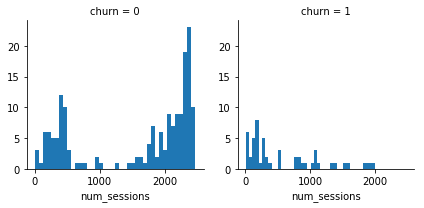

In [81]:
# plot distribution of number of sessions per user
g = sns.FacetGrid(num_sessions, col="churn")
g = g.map(plt.hist, "num_sessions", bins=40)

In [65]:
# calculate average number of items per session per user
avg_num_items = df_churn\
    .groupBy('userId', 'churn', 'sessionId')\
    .agg(F.max('itemInSession').alias('num_items_per_session'))\
    .groupBy('userId', 'churn')\
    .agg(F.avg('num_items_per_session').alias('avg_num_items_per_session'))\
    .toPandas()

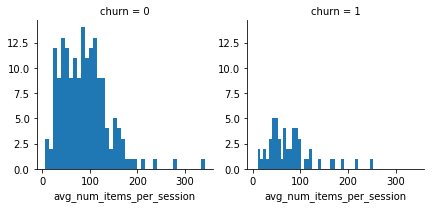

In [80]:
# plot distribution of average number of items per session per user
g = sns.FacetGrid(avg_num_items, col="churn")
g = g.map(plt.hist, "avg_num_items_per_session", bins=40)

It appears that users who churned were less actively using sparkify than users who didn't churn. But these are cumulative values over the entire data collection period. Users might have joined later or canceled earlier. 

So, next we explore some aggregates per given time interval when user was active. Daily statistics might be too fine, so let's look at monthly statistics. We need to define new columns for this: 

In [7]:
# define `date` and `monthYear` columns
df_churn = df_churn.withColumn('date', F.from_unixtime(df_churn['ts']/1000).cast(DateType()))
df_churn = df_churn.withColumn('monthYear', F.concat(F.year('date'), F.month('date')))
df_churn.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, date=datetime.date(2018, 10, 8), monthYear='201810')]

In [75]:
# calculate average number of songs per month (this will only include months when a given user was active)
avg_num_songs_per_month = df_churn\
    .groupBy('userId', 'churn', 'monthYear')\
    .agg(F.count(F.when(F.col('page') == 'NextSong', F.col('page'))).alias('num_songs_per_month'))\
    .groupBy('userId', 'churn')\
    .agg(F.avg('num_songs_per_month').alias('avg_num_songs_per_month'))\
    .toPandas()

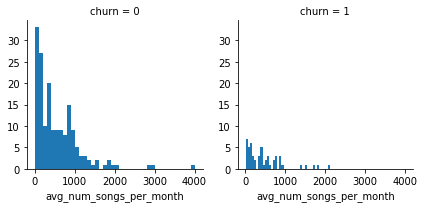

In [79]:
# plot distribution of average number of songs per month per user 
g = sns.FacetGrid(avg_num_songs_per_month, col="churn")
g = g.map(plt.hist, "avg_num_songs_per_month", bins=40)

In [82]:
# calculate average number of sessions per month (this will only include months when a given user was active)
avg_num_sessions_per_month = df_churn\
    .groupBy('userId', 'churn', 'monthYear')\
    .agg(F.max('sessionId').alias('num_sessions_per_month'))\
    .groupBy('userId', 'churn')\
    .agg(F.avg('num_sessions_per_month').alias('avg_num_sessions_per_month'))\
    .toPandas()

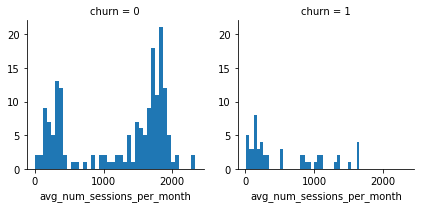

In [83]:
# plot distribution of average number of sessions per month per user 
g = sns.FacetGrid(avg_num_sessions_per_month, col="churn")
g = g.map(plt.hist, "avg_num_sessions_per_month", bins=40)

It appears that monthly averages tell a similar story: users who churned were less actively using sparkify than users who didn't churn. 

As expected measures of activity and commitment are generally higher for users who did not churn. In our feature engineering section we will use features explored above and also add more features for these measures, such as how diverse is a pool of artists that a user listens to, or if a user invests time in building playlists or friend networks. 

Before we proceed, we note that there are a few very active users in both churn group and non-churn group but there is one particular user that is considerably more active than anyone else. We will decide on whether to remove this use or not later. 

# Feature Engineering

Now that we are familiar with the dataset let's build the features that look relevant to churn. Some of the features we already discussed above:

In [8]:
# paid ever
temp = df_churn.select('userId', 'level')\
    .groupBy('userId')\
    .agg(F.when(F.array_contains(F.collect_set('level'), 'paid'), 1).otherwise(0).alias('paid'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['paid'])

In [9]:
# downgraded ever
temp = df_churn.select('userId', 'page')\
    .groupBy('userId')\
    .agg(F.when(F.array_contains(F.collect_set('page'), 'Submit Downgrade'), 1).otherwise(0).alias('downgrade'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['downgrade'])

In [10]:
# upgraded ever
temp = df_churn.select('userId', 'page')\
    .groupBy('userId')\
    .agg(F.when(F.array_contains(F.collect_set('page'), 'Submit Upgrade'), 1).otherwise(0).alias('upgrade'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['upgrade'])

In [11]:
# number of sessions 
temp = df_churn.select('userId', 'sessionId')\
    .groupBy('userId')\
    .agg(F.max('sessionId').alias('num_sessions'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['num_sessions'])

In [12]:
# average number of sessions per month 
temp = df_churn.select('userId', 'sessionId', 'monthYear')\
    .groupBy('userId', 'monthYear')\
    .agg(F.max('sessionId').alias('num_sessions_per_month'))\
    .groupBy('userId')\
    .agg(F.avg('num_sessions_per_month').alias('avg_num_sessions_per_month'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['avg_num_sessions_per_month'])

In [13]:
# average number of items per session
temp = df_churn.select('userId', 'sessionId', 'itemInSession')\
    .groupBy('userId', 'sessionId')\
    .agg(F.max('itemInSession').alias('num_items_per_session'))\
    .groupBy('userId')\
    .agg(F.avg('num_items_per_session').alias('avg_num_items_per_session'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['avg_num_items_per_session'])

In [14]:
# average number of songs per session
temp = df_churn.select('userId', 'sessionId', 'page')\
    .groupBy('userId', 'sessionId')\
    .agg(F.count(F.when(F.col('page') == 'NextSong', F.col('page'))).alias('num_songs_per_session'))\
    .groupBy('userId')\
    .agg(F.avg('num_songs_per_session').alias('avg_num_songs_per_session'))   

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['avg_num_songs_per_session'])

In [15]:
# average number of songs per month
temp = df_churn.select('userId', 'monthYear', 'page')\
    .groupBy('userId', 'monthYear')\
    .agg(F.count(F.when(F.col('page') == 'NextSong', F.col('page'))).alias('num_songs_per_month'))\
    .groupBy('userId')\
    .agg(F.avg('num_songs_per_month').alias('avg_num_songs_per_month'))   

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['avg_num_songs_per_month'])

We will also calculate number of thumbs up/down divided by total number of songs listened, to get an idea of how happy the user was with the content, total number of friends added to get an idea of how large a user's network is (we are not looking at per month data here, as it makes sense to be adding fewer friends if you already added most people you know). We will define total number of songs added and average number of songs added per month to get an idea of the extent of the library a user has built and how commited they are to building it further (we are looking at per month data here because people tend to get bored by listening to the same thing repeatedly, even though they like to come back to favorites every now and then). We will also consider total number of distinct artists and average number of distinct artists per month to get an idea of whether a user is exploring and getting to expand their coverage. And lastly we will create a numeric gender feature and find ratio of `PUT` methods to get a general idea of user behaviour type. 

In [16]:
# total number of thumbs up divided by total number of songs 
temp = df_churn.select('userId', 'page')\
    .groupBy('userId')\
    .agg((F.count(F.when(F.col('page') == 'Thumbs Up', F.col('page'))) / F.count(F.when(F.col('page') == 'NextSong', F.col('page')))).alias('thumbs_up_over_songs'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['thumbs_up_over_songs'])

In [17]:
# total number of thumbs down divided by total number of songs 
temp = df_churn.select('userId', 'page')\
    .groupBy('userId')\
    .agg((F.count(F.when(F.col('page') == 'Thumbs Down', F.col('page'))) / F.count(F.when(F.col('page') == 'NextSong', F.col('page')))).alias('thumbs_down_over_songs'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['thumbs_down_over_songs'])

In [18]:
# total number of friends added
temp = df_churn.select('userId', 'page')\
    .groupBy('userId')\
    .agg(F.count(F.when(F.col('page') == 'Add Friend', F.col('page'))).alias('num_friends_added'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['num_friends_added'])

In [19]:
# total number of songs added to a playlist
temp = df_churn.select('userId', 'page')\
    .groupBy('userId')\
    .agg(F.count(F.when(F.col('page') == 'Add to Playlist', F.col('page'))).alias('num_added_to_playlist'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['num_added_to_playlist'])

In [20]:
# average number of songs added to a playlist per month 
temp = df_churn.select('userId', 'monthYear', 'page')\
    .groupBy('userId', 'monthYear')\
    .agg(F.count(F.when(F.col('page') == 'Add to Playlist', F.col('page'))).alias('num_added_to_playlist_per_month'))\
    .groupBy('userId')\
    .agg(F.avg('num_added_to_playlist_per_month').alias('avg_num_added_to_playlist_per_month'))   

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['avg_num_added_to_playlist_per_month'])

In [21]:
# gender 
temp = df_churn.select('userId', 'gender')\
    .groupBy('userId')\
    .agg((F.when(F.first('gender') == 'M', 1).otherwise(0)).alias('gender_numeric'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['gender_numeric'])

In [22]:
# total number of artists
temp = df_churn.select('userId', 'artist')\
    .groupBy('userId')\
    .agg(F.countDistinct('artist').alias('num_artists'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['num_artists'])

In [23]:
# average number of artists per month 
temp = df_churn.select('userId', 'monthYear', 'artist')\
    .groupBy('userId', 'monthYear')\
    .agg(F.countDistinct('artist').alias('num_artists_per_month'))\
    .groupBy('userId')\
    .agg(F.avg('num_artists_per_month').alias('avg_num_artists_per_month'))   

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['avg_num_artists_per_month'])

In [24]:
# total number of PUT methods over total number of all actions
temp = df_churn.select('userId', 'method')\
    .groupBy('userId')\
    .agg((F.count(F.when(F.col('method') == 'PUT', F.col('method'))) / F.count(F.col('method'))).alias('fraction_of_put'))

users_churn = users_churn\
    .join(temp, users_churn.userId == temp.userId)\
    .select(users_churn["*"],temp['fraction_of_put'])

In [25]:
# take a look at a row from our new dataframe:
users_churn.take(1)

[Row(userId='100010', churn=0, paid=0, downgrade=0, upgrade=0, num_sessions=187, avg_num_sessions_per_month=152.5, avg_num_items_per_session=54.42857142857143, avg_num_songs_per_session=39.285714285714285, avg_num_songs_per_month=137.5, thumbs_up_over_songs=0.06181818181818182, thumbs_down_over_songs=0.01818181818181818, num_friends_added=4, num_added_to_playlist=7, avg_num_added_to_playlist_per_month=3.5, gender_numeric=0, num_artists=252, avg_num_artists_per_month=130.0, fraction_of_put=0.821522309711286)]

Next we examine the user that had very large number of songs per month on their account. 

In [38]:
users_churn.filter(F.col('avg_num_songs_per_month') > 3000).take(1) # there is only one

[Row(userId='39', churn=0, paid=1, downgrade=1, upgrade=1, num_sessions=2459, avg_num_sessions_per_month=1964.0, avg_num_items_per_session=91.88785046728972, avg_num_songs_per_session=74.78504672897196, avg_num_songs_per_month=4001.0, thumbs_up_over_songs=0.04848787803049238, thumbs_down_over_songs=0.008622844288927768, num_friends_added=122, num_added_to_playlist=240, avg_num_added_to_playlist_per_month=120.0, gender_numeric=0, num_artists=3544, avg_num_artists_per_month=2211.5, fraction_of_put=0.9300249169435216)]

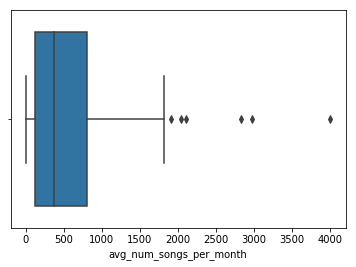

In [36]:
ax = sns.boxplot(x=users_churn.select('avg_num_songs_per_month').toPandas().avg_num_songs_per_month)

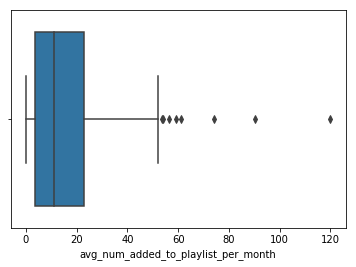

In [42]:
ax = sns.boxplot(x=users_churn.select('avg_num_added_to_playlist_per_month').toPandas().avg_num_added_to_playlist_per_month)

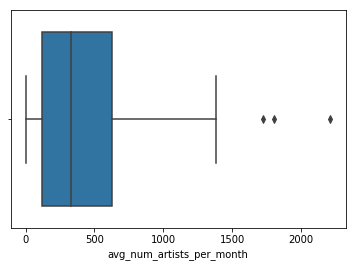

In [43]:
ax = sns.boxplot(x=users_churn.select('avg_num_artists_per_month').toPandas().avg_num_artists_per_month)

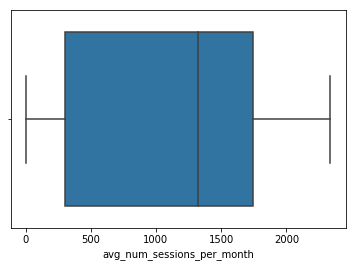

In [44]:
ax = sns.boxplot(x=users_churn.select('avg_num_sessions_per_month').toPandas().avg_num_sessions_per_month)

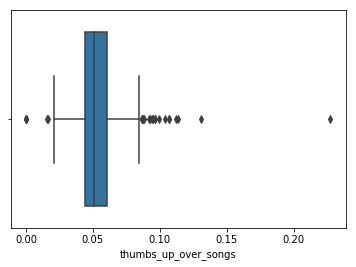

In [45]:
ax = sns.boxplot(x=users_churn.select('thumbs_up_over_songs').toPandas().thumbs_up_over_songs)

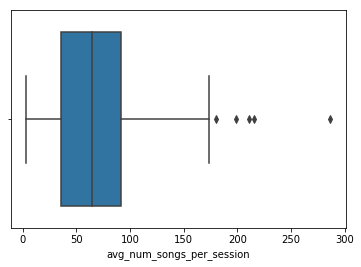

In [47]:
ax = sns.boxplot(x=users_churn.select('avg_num_songs_per_session').toPandas().avg_num_songs_per_session)

We see that this user is has outlier data for number of songs they listen to or add to playlists and number of artists but they are well within the acceptable range for other features such as average number of songs per session, average number of sessions per month and thumbs up over number of songs. So, we will not remove this user from our dataset. 

# Modeling


## Metrics

Before we start building our model we have to decide what metric to use as our models' performance measure, which metric to optimize for. Since churned users are a minority, only about `23.11%`, we will optimize for F1 score that is available through `MulticlassClassificationEvaluator` in pyspark. We will, however, also report accuracy scores for models that we consider. 

## Preprocessing 

We have some preprocessing to do for this dataset. Firstly, we need to assemble the features into a single vector feature. Next, since we will be trying out a logistic regression classifier, a distance based model, we will need to standardize our data.

In [104]:
# assemble features into a vector feature
assembler = VectorAssembler(inputCols=['paid',
 'downgrade',
 'upgrade',
 'num_sessions',
 'avg_num_sessions_per_month',
 'avg_num_items_per_session',
 'avg_num_songs_per_session',
 'avg_num_songs_per_month',
 'thumbs_up_over_songs',
 'thumbs_down_over_songs',
 'num_friends_added',
 'num_added_to_playlist',
 'avg_num_added_to_playlist_per_month',
 'gender_numeric',
 'num_artists',
 'avg_num_artists_per_month',
 'fraction_of_put'], outputCol="features_raw")
data = assembler.transform(users_churn).select(F.col('churn').alias('label'), 'features_raw')

# split data into train, validation and test sets
train, validation, test = data.randomSplit([0.6, 0.2, 0.2], seed=135)

# train a `StandardScaler` on the train set
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scalerModel = scaler.fit(train)

# transform all sets using the trained `StandardScaler`
train_scaled = scalerModel.transform(train)
validation_scaled = scalerModel.transform(validation)
#test_scaled = scalerModel.transform(test)

In [105]:
# check that we have a reasonable number of churned datapoints in each of the sets
train.groupBy('label').agg(F.count('features_raw')).show()
validation.groupBy('label').agg(F.count('features_raw')).show()
test.groupBy('label').agg(F.count('features_raw')).show()

+-----+-------------------+
|label|count(features_raw)|
+-----+-------------------+
|    1|                 31|
|    0|                112|
+-----+-------------------+

+-----+-------------------+
|label|count(features_raw)|
+-----+-------------------+
|    1|                 11|
|    0|                 34|
+-----+-------------------+

+-----+-------------------+
|label|count(features_raw)|
+-----+-------------------+
|    1|                 10|
|    0|                 27|
+-----+-------------------+



In [106]:
# check out our scaled data:
train_scaled.take(1)

[Row(label=0, features_raw=SparseVector(17, {3: 1863.0, 4: 1540.0, 5: 8.2, 6: 7.4, 7: 18.5, 13: 1.0, 14: 37.0, 15: 18.5, 16: 0.8444}), features=DenseVector([-1.7505, -0.5243, -1.189, 0.5217, 0.5965, -1.5889, -1.4852, -1.019, -2.954, -1.3473, -0.9355, -0.9698, -1.0247, 0.9356, -1.1429, -1.1549, -1.1699]))]

In [107]:
# instantiate evaluators
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

There are several classifiers available in Spark ML library. We will try out LogisticRegression and two tree based models, RandomForestClassifier and GBTClassifier. The tree based models are a reasonable choice beacuse we have four one-hot-encoded categorical features (`paid`, `downgrade`, `upgrade`, `gender_numeric`) as well as numeric features (all the rest). Trying out LogisticRegression makes sense because it is simple, relatively inexpensive to train and easy to interpret. 

In [108]:
# Train a LogisticRegression model
lr = LogisticRegression(maxIter=10)
lrModel = lr.fit(train_scaled)

# Make predictions
predictions_lr = lrModel.transform(validation_scaled)\
    .select("features", "label", "prediction")

print('F1 score for Logistic Regression is {}'.format(evaluator_f1.evaluate(predictions_lr)))
print('Accuracy score for Logistic Regression is {}'.format(evaluator_acc.evaluate(predictions_lr)))

F1 score for Logistic Regression is 0.7698412698412699
Accuracy score for Logistic Regression is 0.7777777777777778


In [109]:
# Train a RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(train_scaled)

# Make predictions
predictions_rf = rfModel.transform(validation_scaled)\
    .select("features", "label", "prediction")

print('F1 score for Logistic Regression is {}'.format(evaluator_f1.evaluate(predictions_rf)))
print('Accuracy score for Logistic Regression is {}'.format(evaluator_acc.evaluate(predictions_rf)))

F1 score for Logistic Regression is 0.8870485392224523
Accuracy score for Logistic Regression is 0.8888888888888888


In [110]:
# Train a GBTClassifier model
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbtModel = gbt.fit(train_scaled)

# Make predictions.
predictions_gbt = gbtModel.transform(validation_scaled)\
    .select("features", "label", "prediction")

print('F1 score for Logistic Regression is {}'.format(evaluator_f1.evaluate(predictions_gbt)))
print('Accuracy score for Logistic Regression is {}'.format(evaluator_acc.evaluate(predictions_gbt)))

F1 score for Logistic Regression is 0.7698412698412699
Accuracy score for Logistic Regression is 0.7777777777777778


## Model evaluation and validation

We see that the best model with default parameters is the RandomForestClassifier. We will focus on this model further and try to improve it by tuning the parameters. We will not use scaled data here since it does not matter for tree based models whether data is scaled or not.  

We will merge train and validation sets and instead use a `CrossValidator` to choose the best model during parameter tuning. We will do 3-fold cross-validation. 

In [113]:
# instantiate a classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features").setSeed(12345)

# build a parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5]) \
    .addGrid(rf.minInstancesPerNode, [1, 3])\
    .build()

# build a crossvalidator 
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_f1,
                          numFolds=3) 

In [ ]:
# combine train and validation sets
train_val = train.union(validation)
train_val = train_val.orderBy(F.rand(seed=12345)).select('label', F.col('features_raw').alias('features'))

# Train model  
cvModel = crossval.fit(train_val)

In [117]:
# Make predictions on the test set
predictions_cv = cvModel.transform(test.select('label', F.col('features_raw').alias('features')))\
    .select("features", "label", "prediction")

In [118]:
print('F1 score for the best model is {}'.format(evaluator_f1.evaluate(predictions_cv)))
print('Accuracy score for the best model is {}'.format(evaluator_acc.evaluate(predictions_cv)))

F1 score for the best model is 0.7069765182972729
Accuracy score for the best model is 0.7027027027027027


In [119]:
# check average F1 scores for all models
cvModel.avgMetrics

[0.8184665028328302,
 0.8097276306990502,
 0.8313319530710834,
 0.8486181695734591,
 0.8108159961602587,
 0.8117495246814113,
 0.8234230031708907,
 0.8460876694214798]

In [120]:
# check best parameters from grid search
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]

{Param(parent='RandomForestClassifier_68915c942586', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestClassifier_68915c942586', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='RandomForestClassifier_68915c942586', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}

In [121]:
# check all parameters of the best model
cvModel.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_68915c942586', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_68915c942586', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_68915c942586', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_68915c942586', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_68915c942586', 

## Justification

We have tried out several models and after choosing the best one, a random forest classifier, we further refined it by using grid search with 3-fold cross-validation (which is a more robust method then just train-validation split as it leaves less up to chance of getting a good split) to find the best parameters. It turned out that the best results were given by using 10 trees, maximum tree depth of 5 and minumum instances per node of 3. We used the F1 score to choose the best model, since the label was skewed.  

Finally we evaluate out model on the test set and get F1 score of about `70.7%` and accuracy score of `70.3%`. This is not bad at all since we had 225 data points to work with and could only use `80%` of it for training and validation. With so few points it was very important to find a good balance between bias and variance and it makes sense that Logistic Regression (prone to bias) and Gradient Boosted Trees Classifier (prone to overfitting) were  bested by a Random Forest Classifier. We also see that grid search resulted in minumum instances per node parameter and number of trees parameter being chosen in a way to simplify the model while the maximum tree depth parameter was chosen to make the model more sophisticated thus obtaining the balance. 

# Conclusion

## Reflection

In this notebook we analyzed a dataset for a digital music service that contains data on user actions. Our aim was to understand user satisfaction and predict churn. We cleaned the data to eliminate points that would not add value to our analysis. We defined churn as a user canceling the account and compared and contrasted the features of groups of users who churned versus users did not. This exploration process helped us mine for insights for what affects churn and as a result we engineered 17 features to use in our model. Next we tried out several models and focused on the best one to refine it even further. As a result we built a well-balanced model that gave us F1 score of about `70.7%` and accuracy score of `70.3%`. 

One of the most interesting parts of this project was feature engineering. It was exciting to start with a (cleaned) dataset of 278154 rows and distill insights from this massive amout of information for 225 users. It was also challenging because this was a partial dataset and we did not have full data for given users. For example, we did not have full collection of session items for all sessions, or even all sessions per user. So, we used maximums `sessionId` and `itemInSession` to approximate these values. Also, calculating per month summaries were useful in giving us finer insights. 

## Improvement

There are a few things we could do to improve our model and analysis. For example, we could engineer extra datapoints by treating today's users and users of, say, two months ago as different and checking how their behaviour changed. Perhaps this would help further identify what made a user churn today if they were happy two months ago. Another thing we would improve could be to engineer more features. For example, we could make use of the location column that we did not use in this analysis. The location column has 114 distinct locations at the moment, so we might have to group locations into fewer groups to make it work with 225 datapoints. We could also check if one-hot-encoding `userAgent` has effect on churn. Perhaps looking further into these columns will give us extra insights into the problem at hand and we might be able to build a model that would have higher F1 and accuracy scores.  